# Eco-evolutionary dynamics in consumer-resource models
Zhijie Feng

Here we use constraint optimization mapping to simualte invasion in consumer-resource models. There are several model choises we can make. Here we allow two types of resource dynamics: MacArthur or linear. And we can choose wherther we allow resource to extinct (permanently), and whether new resource invade simultaneously with consumers.
## Models
MacArthur Consumer-Resource Model
\begin{align*}
    \frac{dX_i}{dt} &= X_i (\sum_\alpha c_{i\alpha} R_\alpha - m_i) \\
    \frac{dR_{\alpha}}{dt} &= R_{\alpha}( k_{\alpha} - R_{\alpha} - \sum_j c_{j \alpha} X_j)
\end{align*}

Linear resource dynamics Consumer-Resource Model
\begin{align*}
    \frac{dX_i}{dt} &= X_i (\sum_\alpha c_{i\alpha} R_\alpha - m_i) \\
    \frac{dR_{\alpha}}{dt} &= k_{\alpha} - R_{\alpha} - \sum_j c_{j \alpha} X_jR_{\alpha}
\end{align*}

In [1]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns 
import cvxpy as cvx
from scipy import stats
import time
import pickle
from collections import  defaultdict

In [2]:
cd /Users/zhijie/Documents/GitHub/eco-evolution-simulator

/Users/zhijie/Documents/GitHub/eco-evolution-simulator


In [3]:
from IPython.display import Image


## Invasion dynamics simulation
Here we construct the class TrajectorySimulator to simulate one invasion trajectory with given input parameters. For each step of the trajectory, a indaver is generated, and invade the ecologically stable ecosystem. Since successful invasion is possible only if invader's immediate growth rate is positive, we check it to reduce computation time. We update the ecosystem by computing the new steady state with the invader added.


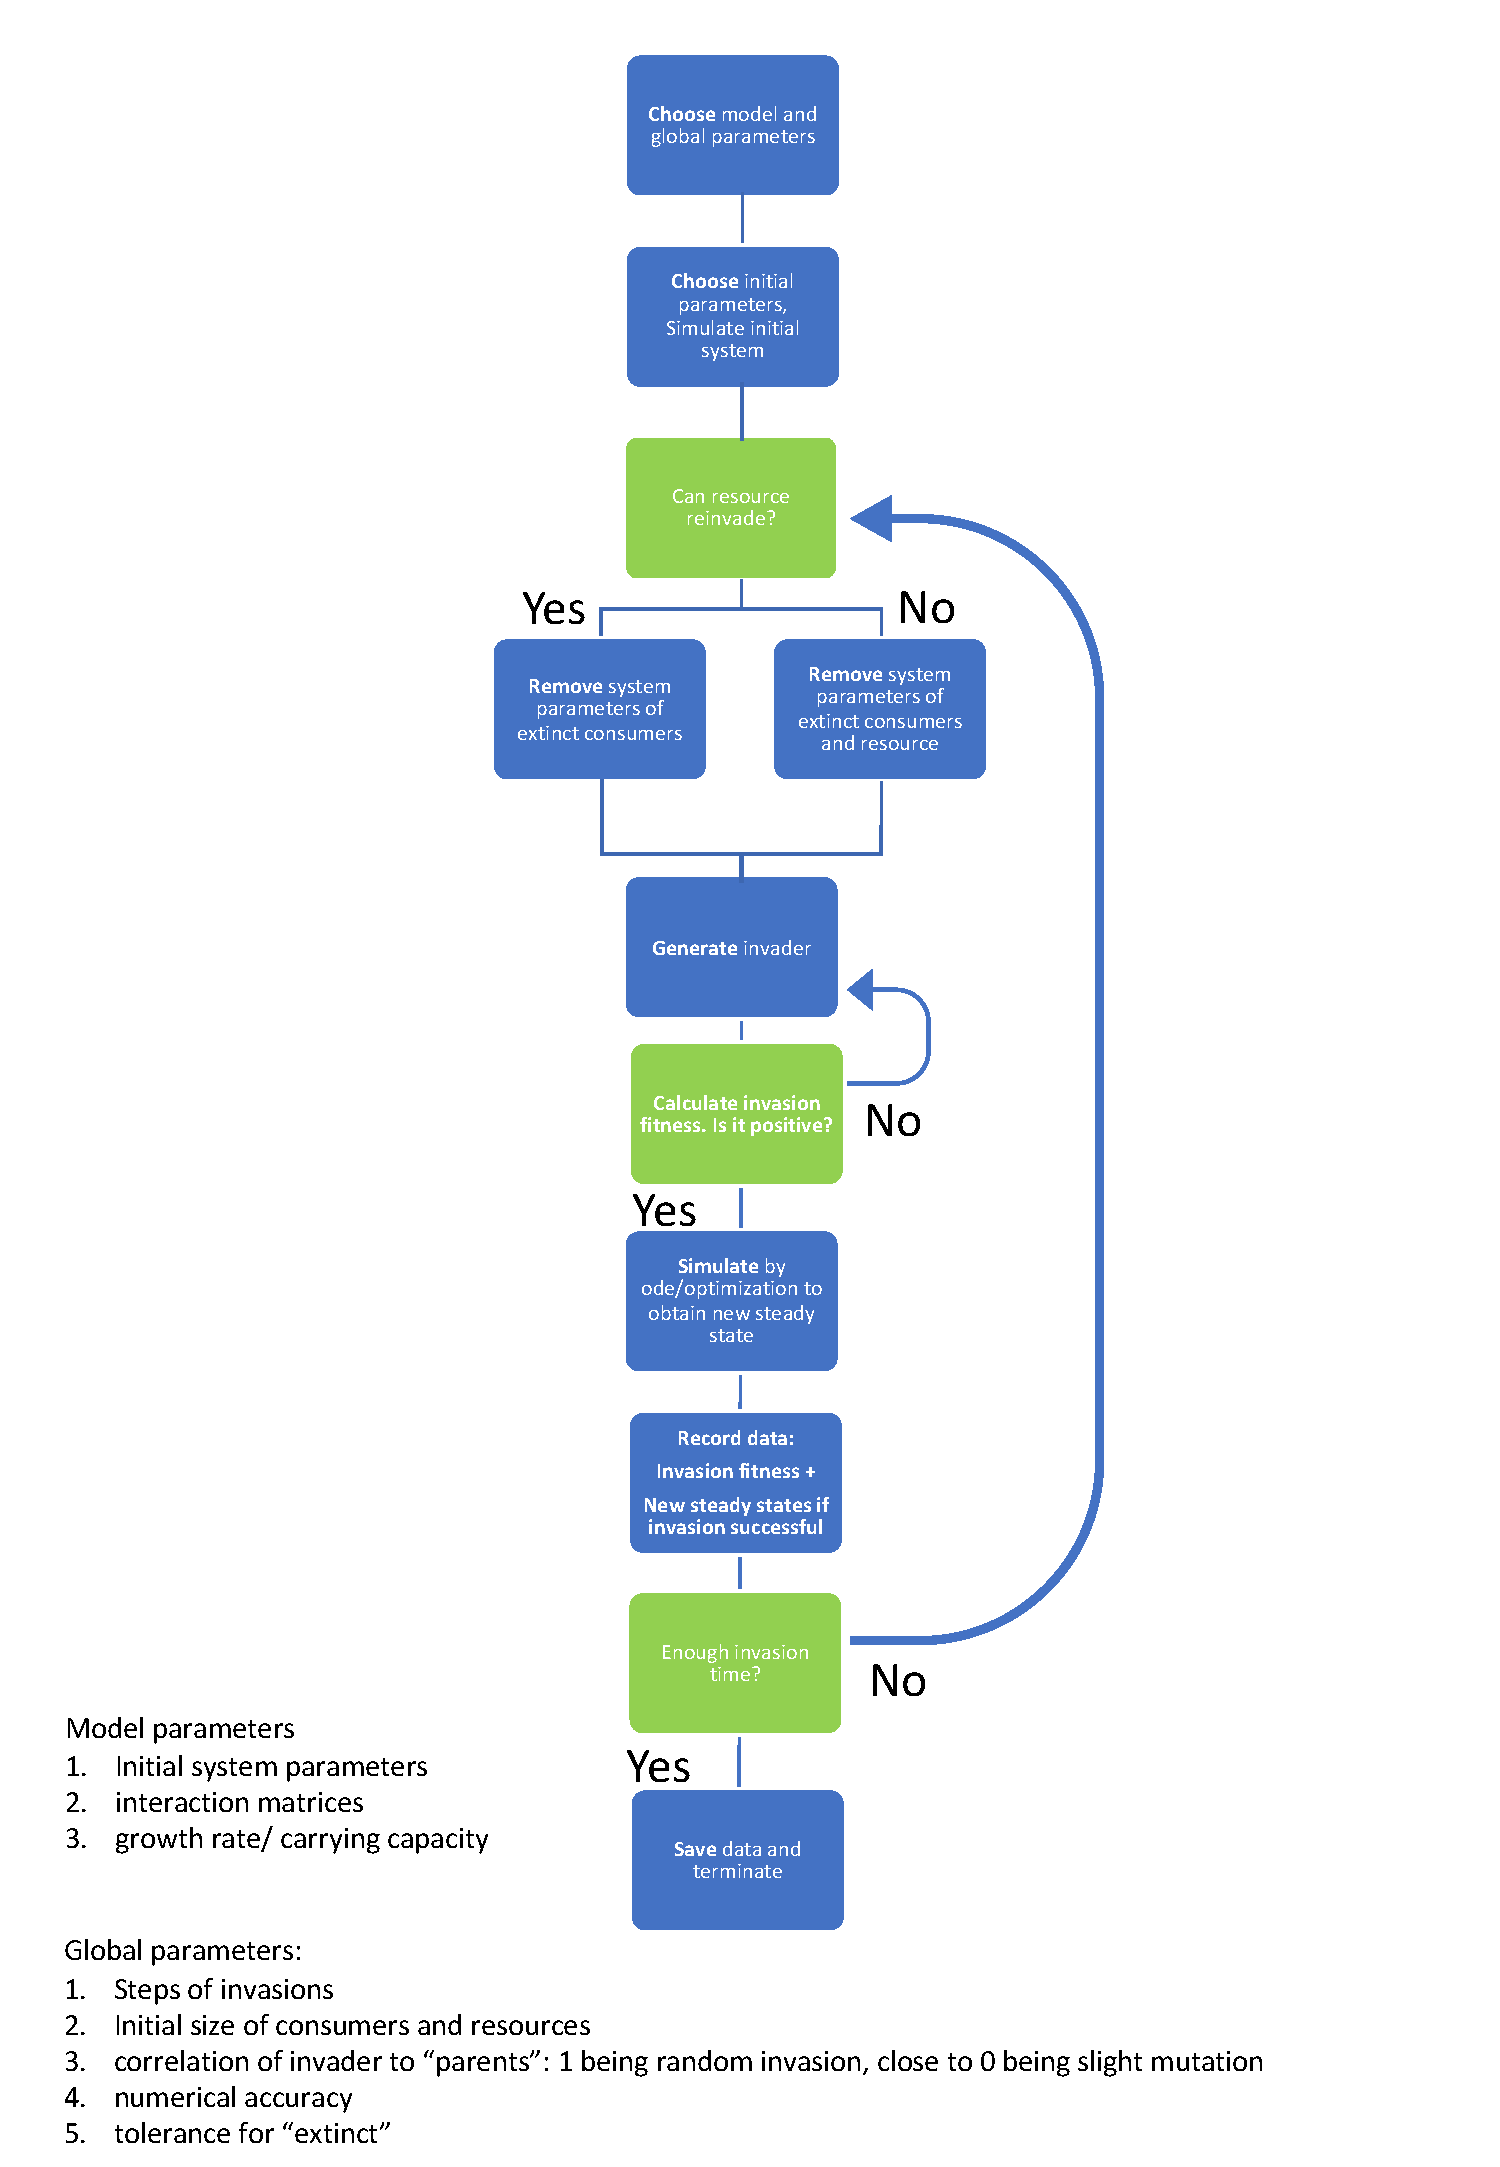

In [4]:
Image("flowchart.png")


In [5]:
class TrajectorySimulator:
    def __init__(self, input_params):
        # Initialize the simulation parameters
        self.top_species = input_params['top_species']
        self.resources = input_params['resources']
        self.mean_k = input_params['mean_k']
        #self.sigma_k = input_params['sigma_k']
        self.mean_m = input_params['mean_m']
        self.sigma_m = input_params['sigma_m']
        self.total_invasion = input_params['total_invasion']
        self.resource_dynamics = input_params['resource_dynamics']
        self.resource_extinct = input_params['resource_extinct']
        self.resource_invade = input_params['resource_invade']
        self.mutation_weight = input_params['mutation_weight']
        self.C_mean = input_params['mean_c']
        self.sigma_c = input_params['sigma_c']

        # Initialize data storage for simulation results by defaultdict, which automatically initialize dictionary elements with empty lists
        self.results=defaultdict(list) 
        # Save the input parameters in the result too
        self.results['input_params'] = input_params


    def initialize_parameters(self):
        # Initialize the consumer and resource matrices and vectors
        self.C = self.C_mean / self.resources + self.sigma_c * np.random.normal(0, 1, (self.top_species, self.resources)) / np.sqrt(self.resources)
        self.m = np.ones(self.top_species) *self.mean_m
        self.k = np.ones(self.resources) * self.mean_k
        self.results['initial_C']=self.C
        self.results['initial_m']=self.m
        self.results['initial_k']=self.k
        
    def record_results(self, invasion, N_opt_value, R_opt_value, top_survived, resources_survived, invasionC, invasionm,invasionR,invasionk):
        # Record simulation results for the successful invasion
        self.results['successful_index'].append(invasion) # the invasion times that sucessful invasion happened
        self.results['List_packing'].append(sum(top_survived) / sum(resources_survived)) #the ratio of number of surviving consumers over number of surviving consumers
        self.results['List_meanfitness'].append(np.mean(self.C @ self.k - self.m))#the system average of CK-m
        self.results['List_N'].append(N_opt_value) #each data is a list of consumer abundance for each species that survive in the last step, plus final element being the invader  
        self.results['List_R'].append(R_opt_value) #each data is a list of resource abundance for each resources that survive in the last step, plus final element being the invader  
        self.results['List_surviveN'].append(top_survived) #each data is a list of boolean variable, being 1 means the consumer is recognized as survived
        self.results['List_surviveR'].append(resources_survived) #each data is a list of boolean variable, being 1 means the resource is recognized as survived
        self.results['List_invasionC'].append(invasionC) #invader's consumer perference
        self.results['List_invasionm'].append(invasionm) #invader's death rate
        if self.resource_invade:
            self.results['List_invasionR'].append(invasionR) #invader's consumer perference
            self.results['List_invasionk'].append(invasionk) #invader's death rate
        #self.results['testC'].append(self.C) # for testing the reconstruct function in SimulationAnalyzer
       
    def all_invasion_record_results(self,invasion_fitness):
        # Record the result for both any invasions
        self.results['List_invasion_fitness'].append(invasion_fitness) #invasion fitness defined as the immediate growth rate of invader when the it is introduced
            
    def invade(self, R_opt_value, resources_survived, invasionC, invasionm, invasionR, invasionk):
        # Add invading species into the model
        self.C, self.m = np.concatenate((self.C, invasionC)), np.concatenate((self.m, invasionm))
        if self.resource_invade:
            self.C, self.k = np.concatenate((self.C, invasionR), axis=1), np.concatenate((self.k, invasionk))

    def extinction(self, top_survived, resources_survived):
        # Handle species extinction in the model
        if self.resource_extinct:
            self.C, self.m, self.k = self.C[top_survived, :][:, resources_survived], self.m[top_survived], self.k[resources_survived]
        else:
            self.C, self.m = self.C[top_survived, :], self.m[top_survived]
            
    def steady_state(self):
        # Calculate the steady-state of the model
        R_opt = cvx.Variable(len(self.k))
        if self.resource_dynamics == 'MCRM':
            constraints = [self.C @ R_opt <= self.m, R_opt >= 0]
            prob = cvx.Problem(cvx.Minimize(0.5 * cvx.sum_squares(R_opt - self.k)), constraints)
            prob_output = prob.solve(solver=cvx.OSQP, eps_abs=1e-7, eps_rel=1e-7, max_iter=100000, warm_start=True, verbose=False)
        elif self.resource_dynamics == 'linear':
            constraints = [self.C @ R_opt <= self.m, R_opt >= 0]
            prob = cvx.Problem(cvx.Minimize(cvx.sum(cvx.kl_div(self.k + 1e-9, R_opt + 1e-9))), constraints)
            prob_output = prob.solve(solver=cvx.ECOS, abstol=1e-7, reltol=1e-7, warm_start=True, verbose=False, max_iters=100000)
        return  prob.constraints[0].dual_value, R_opt.value

    def mutation(self, parent, mutate):
        # Apply mutation to a species
        return self.mutation_weight * mutate + (1 - self.mutation_weight) * parent
    
    def get_invasion_fitness(self, invasionC, invasionm, R_opt_value, resources_survived):
        invasion_fitness = invasionC @ R_opt_value[resources_survived] - invasionm if self.resource_extinct else invasionC @ R_opt_value - invasionm
        if len(invasion_fitness)>1:print("invasion fitness error")
        return invasion_fitness[0]
    
    def generate_uncorrelated_invader(self,top_survived,resources_survived):
        if sum(top_survived)>0: niches_dim =np.shape(self.C)[-1] #usually the dimension of C tells the niche dimension, unless no consumer survive
        elif self.resource_extinct: niches_dim = sum(resources_survived)
        else: niches_dim = len(resources_survived)
        
        invasionC =  self.C_mean / self.resources + self.sigma_c * np.random.normal(0, 1, (1, niches_dim)) / np.sqrt(self.resources)
        invasionm = self.sigma_m*np.random.normal(0, 1, (1))+self.mean_m
        return invasionC, invasionm
    
    def generate_uncorrelated_new_resource(self,top_survived,resources_survived):
        if sum(top_survived)>0: niches_dim =np.shape(self.C)[0]+1 #usually the dimension of C tells the niche dimension, unless no consumer survive
        else: niches_dim = len(top_survived)+1
        # the +1 comes from the fact that consumers invade
        
        invasionR = self.C_mean / self.resources + self.sigma_c * np.random.normal(0, 1, (niches_dim, 1)) / np.sqrt(self.resources)
        invasionk = self.sigma_m*np.random.normal(0, 1, (1))+self.mean_k
        return invasionR, invasionk
    
    def initialize_ecosystem(self):
        top_survived=[]
        while  sum(top_survived) <1: #start ecosystem with at least 1 surviving consumer
            self.initialize_parameters()
            N_opt_value, R_opt_value = self.steady_state()
            return N_opt_value, R_opt_value
        
    def determine_survival(self,N_opt_value,R_opt_value,N_threshold=1e-5, R_threshold=1e-5):
        return N_opt_value > N_threshold, R_opt_value > R_threshold
    
    def run_simulation(self):
        N_opt_value, R_opt_value=self.initialize_ecosystem()
        top_survived, resources_survived = self.determine_survival(N_opt_value,R_opt_value)
        old_N_opt_value = N_opt_value
        List_invasion_fitness = []
        
        for invasion in range(self.total_invasion):
            invasionC, invasionm = self.generate_uncorrelated_invader(top_survived,resources_survived)
            if self.resource_invade: 
                invasionR, invasionk = self.generate_uncorrelated_new_resource(top_survived,resources_survived)
            else: invasionR, invasionk = None, None
                
            if self.mutation_weight > 0:
                parent_index = np.random.randint(len(self.C))
                invasionC, invasionm = self.mutation(np.array([self.C[parent_index]]), invasionC), self.mutation(np.array([self.m[parent_index]]), invasionm)

            invasion_fitness = self.get_invasion_fitness(invasionC, invasionm, R_opt_value, resources_survived)
            self.all_invasion_record_results(invasion_fitness)
            if self.resource_invade: invadebool=1
            else:
                invadebool = invasion_fitness > 0 #invasion only possible when immediate growth rate is positive
            
            if invadebool:     
                self.invade(R_opt_value, resources_survived, invasionC, invasionm, invasionR, invasionk)
                N_opt_value, R_opt_value = self.steady_state() 
                top_survived, resources_survived = self.determine_survival(N_opt_value,R_opt_value)
                self.extinction(top_survived, resources_survived) 
                    
                if not np.array_equal(N_opt_value, old_N_opt_value): # Only record when invasion is successful
                    old_N_opt_value = N_opt_value
                    self.record_results(invasion, N_opt_value, R_opt_value, top_survived, resources_survived,invasionC, invasionm, invasionR, invasionk)
                    
        return self.results

#Here is an easy example to check if the simulation is working
if __name__ == '__main__':
    input_params = {
        'top_species': 1, # initial number of species of consumers
        'resources': 30, # initial number of species of resources
        'mean_k': 5, #mean value of k
        #'sigma_k': 0.1, #standard deviation of k
        'mean_m': 1, #mean value of m
        'sigma_m': 0.1, #standard deviation of k
        'total_invasion': 100000, #total number of invasion steps
        'resource_dynamics': 'MCRM', #type of resource dynamics in the model, it can be 'MCRR' or 'linear'
        'resource_extinct': False, # whether we remove resource permenantly if it extinct in one invasion step
        'resource_invade': False, # whether we simultaneously let a random resource invade
        'mutation_weight': 0.01, # correlation of invader to “parents”: 1 being random invasion, ->0 being slight mutation
        'mean_c' : 1,#mean value of element of C
        'sigma_c' : 0.5 #standard deviation of element of C
    }
    
    start_time = time.time()
    
    simulator = TrajectorySimulator(input_params)
    oneresult = simulator.run_simulation()
    
    print("--- %s seconds ---" % (time.time() - start_time))


--- 11.222244024276733 seconds ---


## Simulation Analyzer
We use SimulationAnalyzer class to process the data to reconstruct the full dynamics, and obtain meaningful output for plotting.

In [6]:
class SimulationAnalyzer:
    def __init__(self, results):
        self.results = results

    def get_mean_variance_total_N(self):
        N_values = self.results['List_N']
        mean_N = [np.mean(N) for N in N_values]
        variance_N = [np.var(N) for N in N_values]
        total_N=[np.sum(N) for N in N_values]
        return np.array(mean_N), np.array(variance_N), np.array(total_N)
    
    def get_mean_variance_total_R(self):
        R_values = self.results['List_R']
        mean_R = [np.mean(R) for R in R_values]
        variance_R = [np.var(R) for R in R_values]
        total_R=[np.sum(R) for R in R_values]
        return np.array(mean_R), np.array(variance_R), np.array(total_R)
    
    def get_N_R_num_survived(self):
        N_survive, R_survive=self.results['List_surviveN'],self.results['List_surviveR']
        num_N_survived=[np.sum(survivalbool) for survivalbool in N_survive]
        num_R_survived=[np.sum(survivalbool) for survivalbool in R_survive]
        return np.array(num_N_survived), np.array(num_R_survived), np.array(total_R)
    
    def get_diff_N_R(self):
        N_values, R_values = self.results['List_N'], self.results['List_R']
        Ndiff, Rdiff = [], []
        
        #to get delta N and R, first remove all extinct species, and add a 0 at the last, finally subtract with with the next vector
        for i in range(len(self.results['List_invasionC'])-1):
            
            top_survived = self.results['List_surviveN'][i]
            resources_survived = self.results['List_surviveR'][i]
            this_N = N_values[i]
            next_N = N_values[i+1]
            this_N = this_N [top_survived]
            #this_N.append([])
            this_N=np.concatenate((this_N,np.array([0])))
            
            #print(this_N, next_N, top_survived)
            Ndiff.append(np.array(next_N)-np.array(this_N))
            this_R = R_values[i]
            next_R = R_values[i+1]
            #print(this_R, next_R, resources_survived)
            if self.results['input_params']['resource_extinct'] : this_R = this_R [resources_survived]
            #this_R.append([])
            if self.results['input_params']['resource_invade'] : this_R=np.concatenate((this_R,np.array([0])))
            Rdiff.append(np.array(next_R)-np.array(this_R))
                        
        return Ndiff, Rdiff
    

    
    def reconstruct_extinction(self, top_survived, resources_survived, C, m, k):
        if self.results['input_params']['resource_extinct']:
            new_C, new_m, new_k = C[top_survived, :][:, resources_survived],m[top_survived], k[resources_survived]
        else:
            new_C, new_m, new_k = C[top_survived, :], m[top_survived], k
        return  new_C, new_m, new_k
    
    def reconstruct_invade(self, invasion_C, invasion_m, invasion_R, invasion_k, C, m, k) :
        new_C, new_m, new_k = np.concatenate((C, invasion_C)), np.concatenate((m, invasion_m)), k
        resources=self.results['input_params']['resources']
        if self.results['input_params']['resource_invade']:
            new_C, new_k = np.concatenate((new_C, invasion_R), axis=1), np.concatenate((new_k, invasion_k))
        return new_C, new_m, new_k
    
    
    
    def reconstruct_C_m_k(self):
        C = self.results['initial_C'].copy()
        m = self.results['initial_m'].copy()
        k = self.results['initial_k'].copy()

        reconstructed_C = []
        reconstructed_m = []
        reconstructed_k = []

        for i in range(len(self.results['List_invasionC'])):
            top_survived = self.results['List_surviveN'][i]
            resources_survived = self.results['List_surviveR'][i]
            
            invasion_C = self.results['List_invasionC'][i]
            invasion_m = self.results['List_invasionm'][i]
            

            if self.results['input_params']['resource_invade']:
                invasion_R = self.results['List_invasionR'][i]
                invasion_k = self.results['List_invasionk'][i]
                
            else: invasion_R, invasion_k = None, None
             # Update the current state with the invasion data
            C, m, k = self.reconstruct_invade(invasion_C, invasion_m, invasion_R, invasion_k, C, m, k) 
           
            # Update the current state with the extinction data
            C, m, k = self.reconstruct_extinction(top_survived, resources_survived, C, m, k)
            
            
            # Append the current state to the lists
            reconstructed_C.append(np.array(C.copy()))
            reconstructed_m.append(np.array(m.copy()))
            reconstructed_k.append(np.array(k.copy()))

        return reconstructed_C, reconstructed_m, reconstructed_k

# Demonstrate assuming you have oneresult as the simulation results
analyzer = SimulationAnalyzer(oneresult)

#for testing reconstruction
#listC, listm, listk=analyzer.reconstruct_C_m_k()
#for i in range(len(listC)):
#    if not np.allclose(listC[i],oneresult['testC'][i]): print('no')

# Iteration
We construct functions to iterate any number of parameters over specified ranges, with parrallel computing. And we save the result with pickle.

In [7]:

from joblib import Parallel, delayed

def run_simulation(input_params):
    # Create a TrajectorySimulator instance
    simulator = TrajectorySimulator(input_params)

    # Run the simulation for the given input parameters
    result = simulator.run_simulation()

    return result

def iterate_over_parameter_ranges(parameter_ranges, common_input_params):
    results_dict = {}

    # Create a list of dictionaries representing all combinations of parameter values
    param_combinations = []

    for param1_value in parameter_ranges[0]['values']:
        for param2_value in parameter_ranges[1]['values']:
            input_params = {
                **common_input_params,  # Use the common parameters
                parameter_ranges[0]['param_name']: param1_value,
                parameter_ranges[1]['param_name']: param2_value
            }
            param_combinations.append(input_params)

    # Use joblib to parallelize the execution of simulations
    results = Parallel(n_jobs=-1)(delayed(run_simulation)(input_params) for input_params in param_combinations)

    # Iterate over all parameter combinations and store the results
    for i, input_params in enumerate(param_combinations):
        result = results[i]

        # Create a key that combines both parameter values
        param_key = f"{parameter_ranges[0]['param_name']}={input_params[parameter_ranges[0]['param_name']]}_" \
                    f"{parameter_ranges[1]['param_name']}={input_params[parameter_ranges[1]['param_name']]}"

        # Store the results in the dictionary with the combined parameter key
        results_dict[param_key] = result

    # Save the results to a file using pickle
    with open(filename, 'wb') as file:
        pickle.dump(results_dict, file)

start_time = time.time()
filename = 'simulation_results.pkl'

if __name__ == '__main__':
    # Define parameter ranges 
    parameter_ranges = [
        {
            'param_name': 'mean_k',
            'values': [ 10, 15]
        },
        {
            'param_name': 'mutation_weight',
            'values': [0.01, 0.1, 1]
        }       
        # Add more parameter ranges as needed
    ]

    # Common input parameters
    common_input_params = {
        'top_species': 3,
        'resources': 30,
        'mean_c': 1,
        'sigma_c': 1,
        'total_invasion': 10000,
        'resource_dynamics': 'MCRM',
        'resource_extinct': False,
        'resource_invade': False,
        'mutation_weight': 0.01,
        'mean_m':1,
        'sigma_m':0.1,
        'sigma_k':0.1
    }

    # Call the function to iterate over parameter ranges and run simulations
    iterate_over_parameter_ranges(parameter_ranges, common_input_params)
print("--- %s seconds ---" % (time.time() - start_time))

--- 10.232436895370483 seconds ---


# Visualization
Here we visualize the result we collected from the simulations

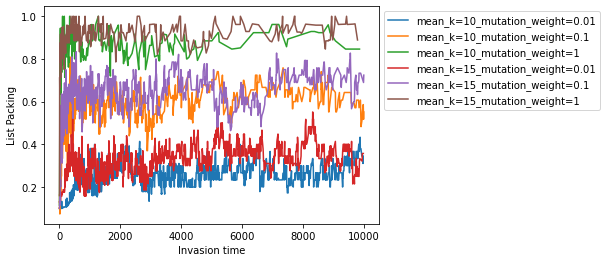

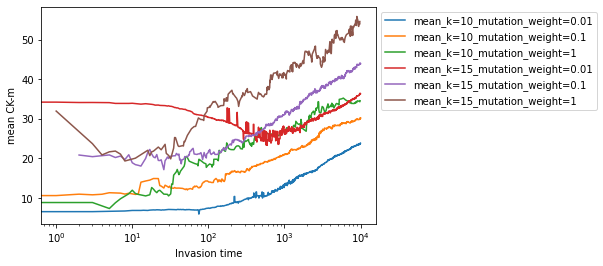

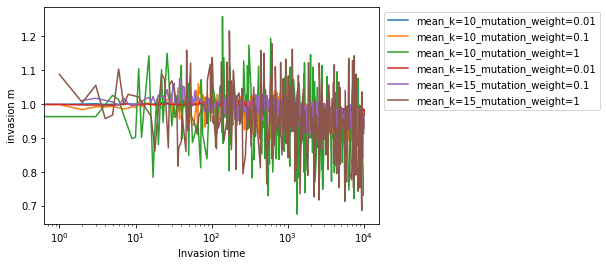

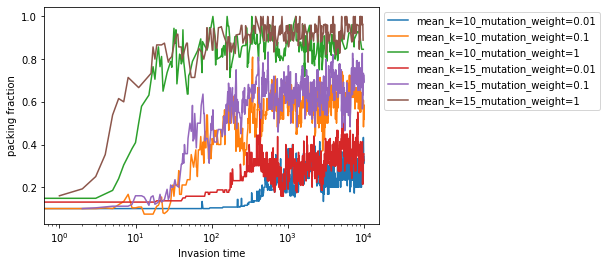

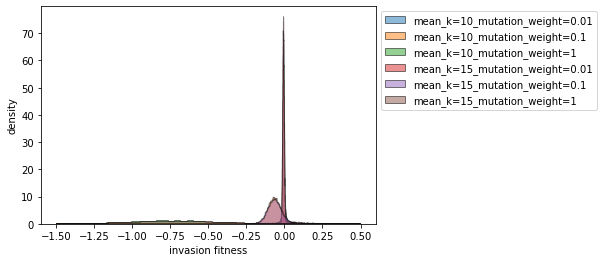

In [8]:
def load_results(filename):
    with open(filename, 'rb') as file:
        results_dict = pickle.load(file)
    return results_dict

def plot_2d_results(results_dict, x_data, y_data, x_label, y_label, xscale='linear', yscale='linear'):
    for param_key, result in results_dict.items():
        x_values = result[x_data]
        y_values = result[y_data]
        plt.plot(x_values, y_values, label=param_key,)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(yscale) 
    plt.xscale(xscale) 
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

    
def iterate_plot(results_dict, analyzer_function, x_label, y_label, xscale='linear', yscale='linear'):
    for param_key, result in results_dict.items():
        x_values = result[x_data]
        y_values = result[y_data]
        plt.plot(x_values, y_values, label=param_key,)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(yscale) 
    plt.xscale(xscale) 
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
    
def plot_histogram_results(results_dict, data, x_label, y_label, kwargs):
    for param_key, result in results_dict.items():
        values = result[data]
        plt.hist(values, **kwargs,label=param_key,)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()    
    
if __name__ == '__main__':
    # Load the saved results
    
    results_dict = load_results(filename)


    plot_2d_results(results_dict, 'successful_index', 'List_packing', 'Invasion time', 'List Packing')
    plot_2d_results(results_dict, 'successful_index','List_meanfitness','Invasion time','mean CK-m',xscale='log')
    

    plot_2d_results(results_dict, 'successful_index','List_invasionm','Invasion time','invasion m',xscale='log')
    plot_2d_results(results_dict, 'successful_index','List_packing','Invasion time','packing fraction',xscale='log')
    
        
    kwargs = dict(histtype='stepfilled', alpha=0.5, density=True, bins='auto', ec="k",range=[-1.5,0.5])
    plot_histogram_results(results_dict,"List_invasion_fitness", "invasion fitness","density", kwargs)

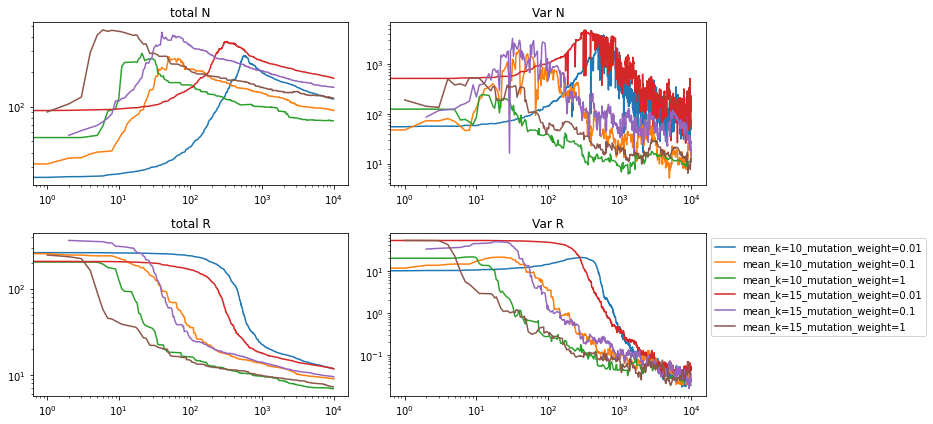

<Figure size 1440x288 with 0 Axes>

In [9]:
fig, axs = plt.subplots(2, 2,figsize=(10, 6))
plt.figure().set_figwidth(20)

axs[0, 0].set_title('total N')
axs[0, 1].set_title('Var N')
axs[1, 0].set_title('total R')
axs[1, 1].set_title('Var R')

for param_key, result in results_dict.items():
        analyzer = SimulationAnalyzer(result)
        x_values = result['successful_index']
        _, variance_N, totalN = analyzer.get_mean_variance_total_N()
        _, variance_R, totalR = analyzer.get_mean_variance_total_R()
        axs[0,0].plot(x_values,totalN, label=param_key)
        axs[0,1].plot(x_values,variance_N, label=param_key)
        axs[1,0].plot(x_values,totalR, label=param_key)
        axs[1,1].plot(x_values,variance_R, label=param_key)
axs[0,0].set_yscale('log')
axs[0,1].set_yscale('log')
axs[1,0].set_yscale('log')
axs[1,1].set_yscale('log')
axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')
fig.tight_layout()
axs[1,1].legend(bbox_to_anchor=(1, 1))

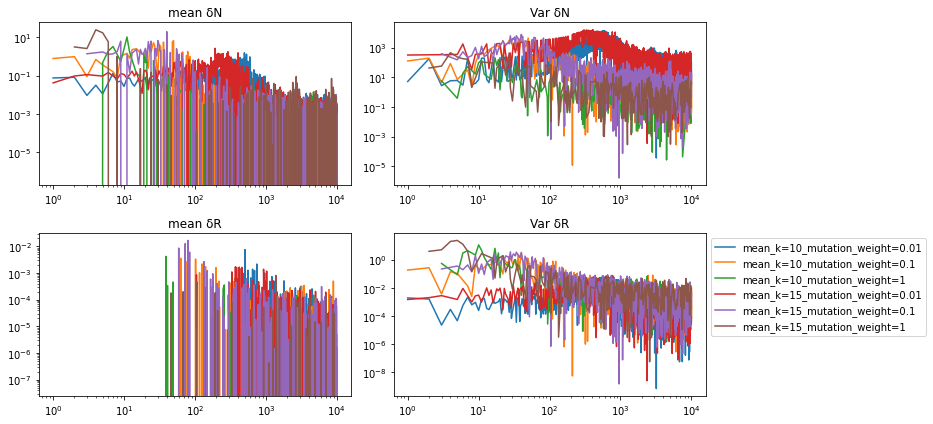

<Figure size 1440x288 with 0 Axes>

In [10]:

fig, axs = plt.subplots(2, 2,figsize=(10, 6))
plt.figure().set_figwidth(20)

axs[0, 0].set_title('mean δN')
axs[0, 1].set_title('Var δN')
axs[1, 0].set_title('mean δR')
axs[1, 1].set_title('Var δR')

for param_key, result in results_dict.items():
        analyzer = SimulationAnalyzer(result)
        x_values = result['successful_index'][1:]
        Ndiff, Rdiff=analyzer.get_diff_N_R()
       
        meanNdiff=[]
        varNdiff=[]
        meanRdiff=[]
        varRdiff=[]
        
        for i in range(len(Ndiff)):
            meanNdiff.append(np.mean(Ndiff[i]))
            varNdiff.append(np.var(Ndiff[i]))
            meanRdiff.append(np.mean(Rdiff[i]))
            varRdiff.append(np.var(Rdiff[i]))
            
                   
        axs[0,0].plot(x_values, meanNdiff, label=param_key)
        axs[0,1].plot(x_values,varNdiff, label=param_key)
        axs[1,0].plot(x_values,meanRdiff, label=param_key)
        axs[1,1].plot(x_values,varRdiff, label=param_key)
        
        axs[0,0].set_yscale('log')
        axs[0,1].set_yscale('log')
        axs[1,0].set_yscale('log')
        axs[1,1].set_yscale('log')
        axs[0,0].set_xscale('log')
        axs[0,1].set_xscale('log')
        axs[1,0].set_xscale('log')
        axs[1,1].set_xscale('log')
fig.tight_layout()

axs[1,1].legend(bbox_to_anchor=(1, 1))


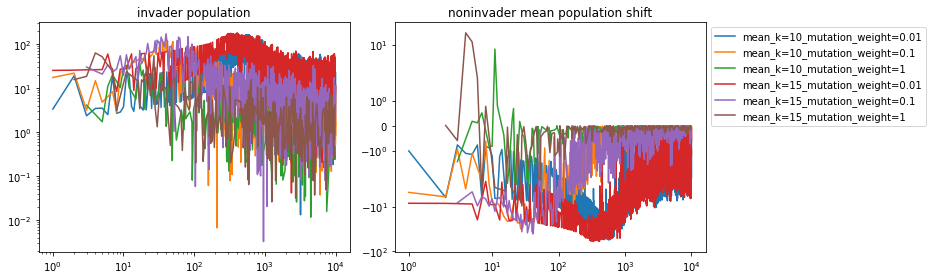

<Figure size 1440x288 with 0 Axes>

In [11]:

fig, axs = plt.subplots(1, 2,figsize=(10, 4))
plt.figure().set_figwidth(20)

axs[0].set_title('invader population')
axs[1].set_title('noninvader mean population shift')

for param_key, result in results_dict.items():
        analyzer = SimulationAnalyzer(result)
        x_values = result['successful_index'][1:]
        Ndiff, Rdiff=analyzer.get_diff_N_R()
       
        invaderpopulation=[]
        noninvaderpopulation=[]
        for i in range(len(Ndiff)):
            invaderpopulation.append(Ndiff[i][-1])
            noninvaderpopulation.append(np.mean(Ndiff[i][:-1]))
            
                   
        axs[0].plot(x_values, invaderpopulation, label=param_key)
        axs[1].plot(x_values, noninvaderpopulation, label=param_key)
        axs[0].set_yscale('log')
        axs[1].set_yscale('symlog')
        axs[0].set_xscale('log')
        axs[1].set_xscale('symlog')

fig.tight_layout()

axs[1].legend(bbox_to_anchor=(1, 1))

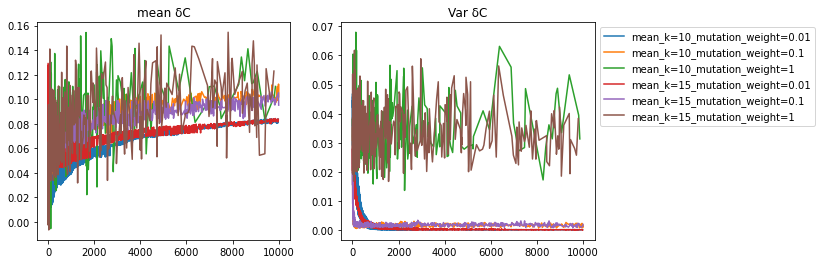

<Figure size 1440x288 with 0 Axes>

In [12]:

fig, axs = plt.subplots(1, 2,figsize=(10, 4))
plt.figure().set_figwidth(20)

axs[ 0].set_title('mean δC')
axs[ 1].set_title('Var δC')


for param_key, result in results_dict.items():
        analyzer = SimulationAnalyzer(result)
        x_values = result['successful_index']
        mean_invader_C, var_invader_C = [],[]
        reconstructed_C, reconstructed_m, _=analyzer.reconstruct_C_m_k()
        for i in range(len(reconstructed_C)):
            mean_invader_C.append(np.mean(reconstructed_C[i][-1]))
            var_invader_C.append(np.var(reconstructed_C[i][-1]))
        axs[0].plot(x_values, mean_invader_C, label=param_key)
        axs[1].plot(x_values,var_invader_C, label=param_key)
axs[1].legend(bbox_to_anchor=(1, 1))

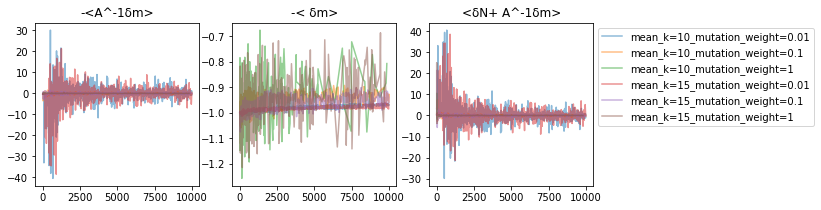

<Figure size 1440x288 with 0 Axes>

In [13]:

fig, axs = plt.subplots(1, 3,figsize=(10, 3))
plt.figure().set_figwidth(20)

axs[0].set_title('-<A^-1δm>')
axs[1].set_title('-< δm>')
axs[2].set_title('<δN+ A^-1δm>')


for param_key, result in results_dict.items():
        analyzer = SimulationAnalyzer(result)
        x_values = result['successful_index'][1:]
        listinvasionm=result['List_invasionm']
            
        mean_Ainv_deltam = []
        mean_deltam=[]
        reconstructed_C, reconstructed_m, _=analyzer.reconstruct_C_m_k()
        
        Ndiff, Rdiff=analyzer.get_diff_N_R()
        meanNdiff=[]   
            
        for i in range(0,len(reconstructed_C)-1):
            meanNdiff.append(np.mean(Ndiff[i]))
            C=reconstructed_C[i]
            A=C@np.transpose(C)
            Ainv=np.linalg.inv(A)
            #unfinished from here
            deltam=listinvasionm[i]
            
            mean_Ainv_deltam.append(np.mean(np.transpose(Ainv)[-1]*deltam))
            mean_deltam.append(np.mean(deltam))
            
        axs[0].plot(x_values,-np.array(mean_Ainv_deltam), label=param_key,alpha=0.5)
        
        axs[1].plot(x_values,-np.array(mean_deltam), label=param_key,alpha=0.5)
        axs[2].plot(x_values,(np.array(meanNdiff)+np.array(mean_Ainv_deltam)), label=param_key,alpha=0.5)
        #axs[2].set_yscale('log')
axs[2].legend(bbox_to_anchor=(1, 1))



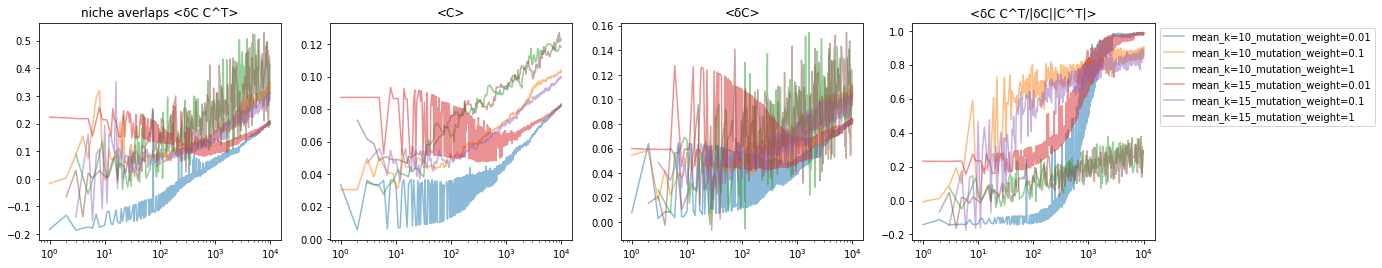

<Figure size 1440x288 with 0 Axes>

In [25]:

fig, axs = plt.subplots(1, 4,figsize=(20, 4))
plt.figure().set_figwidth(20)

axs[0].set_title('niche averlaps <δC C^T>')
axs[1].set_title('<C>')
axs[2].set_title('<δC>')
#axs[3].set_title('<δC C^T>/<C>/<δC>')
axs[3].set_title('<δC C^T/|δC||C^T|>')

for param_key, result in results_dict.items():
        analyzer = SimulationAnalyzer(result)
        x_values = result['successful_index'][1:]
        listinvasionc=result['List_invasionC']
        reconstructed_C, reconstructed_m, _=analyzer.reconstruct_C_m_k()
        nicheoverlaps=[]
        Caverage=[]
        invasionCaverage=[]
        norm_niches_overlaps=[]
        for i in range(1,len(reconstructed_C)):
            C=reconstructed_C[i][:-1] #C excludes the invader itself
            Caverage.append(np.mean(np.ndarray.flatten(C)))
            nicheoverlaps.append(np.mean(C@listinvasionc[i][0]))
            invasionCaverage.append(np.mean(listinvasionc[i][0]))
            norm_niches_overlaps.append(np.mean(np.array(C@listinvasionc[i][0])/np.linalg.norm(C,axis=1)/np.linalg.norm(listinvasionc[i][0])))
        axs[0].plot(x_values,nicheoverlaps, label=param_key,alpha=0.5)
        axs[1].plot(x_values,Caverage, label=param_key,alpha=0.5)
        axs[2].plot(x_values,invasionCaverage, label=param_key,alpha=0.5)
        
        #axs[3].plot(x_values,np.array(nicheoverlaps)/np.array(Caverage)/np.array(invasionCaverage), label=param_key,alpha=0.5)
        axs[3].plot(x_values,norm_niches_overlaps, label=param_key,alpha=0.5)
        
        
        axs[0].set_xscale('log')
        axs[1].set_xscale('log')
        axs[2].set_xscale('log')
        axs[3].set_xscale('log')
        
        
        
axs[3].legend(bbox_to_anchor=(1, 1))

